In [51]:
import json
import datetime
import re
import itertools

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from queryrunner_client import Client as QRClient
#from batch_utils.batch_querier import BatchQuerier
from mdstk.data_fetcher.data_fetcher import DataFetcher
from mdstk.data_fetcher.cached_data_fetcher import CachedDataFetcher

from dataclasses import dataclass


#from queryrunner_client import Client
#qclient = Client(user_email='mehrdad@uber.com')

import os
import pulp
import warnings
warnings.filterwarnings('ignore')
import multiprocessing
from joblib import Parallel, delayed
#num_cores = multiprocessing.cpu_count()
n_cores = 4


# Fetch Data

In [52]:
USER_EMAIL = 'mehrdadb@uber.com'
CONSUMER_NAME = 'intelligentdispatch'

QUERY = """
with dispatch as (
    select 
        datestr,
        msg.cityid,
        msg.ctplangenrequestuuid as plangen_uuid,
        msg.ctrequestuuid as scan_uuid,
        msg.jobuuid[1] as job_uuid,
        msg.supplyuuid,
        msg.planactiontype
    from rawdata_user.kafka_hp_multileg_dispatched_plan_nodedup
    where datestr = '{datestr}'
    and msg.cityid = {city_id}
    and msg.vehicleviewid in {vvid} 
    and msg.tenancy = 'uber/production'
    and CARDINALITY(msg.jobuuid) > 0
    and substr(msg.ctrequestuuid, 1, length('{digits}')) = '{digits}'
),
plangen as (
    select 
        msg.jobs[1].uuid as job_uuid,
        msg.supplyuuid,
        msg.scanuuid as plangen_uuid,
        msg.waypoints[1].latitude as pickup_latitude
    from rawdata_user.kafka_hp_plangenerator_matching_plans_log_nodedup
    where datestr = '{datestr}'
    and msg.cityid = {city_id}
    and msg.tenancy = 'uber/production'
    and CARDINALITY(msg.jobs) > 0
    and msg.planstatus = 'eligible'
),
mgv as (
    select datestr,
           msg.city_id,
           msg.job_uuid,
           msg.client_uuid,
           msg.ct_request_uuid as plangen_uuid,
           msg.supply_uuid,
           msg.supply_plan_uuid as plan_uuid,
           msg.unadjusted_eta as eta,
           msg.fd_eta,
           msg.adjustedeta,
           msg.ranking_metric,
           round(1 - msg.solo_cancel_model_driver_accept_prob, 4) as d_proba,
           round(1 - msg.solo_cancel_model_rider_accept_prob, 4) as r_proba,
           round(1 - msg.spinner_survive_prob_before_next_scan, 4) as s_proba,
           msg.preferred_destination_adjustment,
           msg.objective_value as of_value,
           msg.inconvenience_etd - msg.ranking_metric as trip_length,
           msg.pickup_latitude as pickup_latitude,
           msg.pickup_longitude as pickup_longitude,
           msg.supply_latitude as supply_latitude,
           msg.supply_longitude as supply_longitude
    from   rawdata.kafka_hp_multileg_mgv_log_nodedup
    where  datestr = '{datestr}'
    and    msg.city_id = {city_id}
    and    msg.tenancy = 'uber/production'
    and    msg.vehicle_view_id in {vvid} 
    and    msg.flow_type = 'solo_batch'
    and    msg.job_uuid <> msg.client_uuid
),
test as (
    select 
        mgv.datestr,
        mgv.city_id,
        plangen.pickup_latitude as plangen_pickup_lat,
        dispatch.scan_uuid,
        mgv.plangen_uuid,
        mgv.job_uuid,
        dispatch.planactiontype,
        mgv.supply_uuid,
        case when dispatch.supplyuuid = mgv.supply_uuid then 1 else 0 end as is_selected,
        mgv.eta,
        mgv.adjustedeta,
        mgv.fd_eta,
        mgv.ranking_metric,
        mgv.d_proba,
        mgv.r_proba,
        mgv.s_proba,
        mgv.preferred_destination_adjustment,
        mgv.of_value,
        mgv.trip_length,
        ftf.est_rider_quoted_final_fare as upfront_fare,
        ftf.est_rider_rsp_multiplier,
        ft.surge_multiplier,
        case when fst.trip_uuid is null then 0 else 1 end as is_scheduled_trip,
        fst.upfront_fare as fst_upfront_fare,
        fst.reservation_variant,
        mgv.pickup_latitude as mgv_pickup_lat,
        mgv.pickup_longitude as mgv_pickup_lng,
        mgv.supply_latitude as mgv_supply_lat,
        mgv.supply_longitude as mgv_supply_lng
    from mgv
    join plangen
    on mgv.plangen_uuid = plangen.plangen_uuid
    and mgv.job_uuid = plangen.job_uuid
    and mgv.supply_uuid = plangen.supplyuuid
    join dispatch
    on mgv.plangen_uuid = dispatch.plangen_uuid
    and mgv.job_uuid = dispatch.job_uuid
    join dwh.fact_trip_fare ftf
    on mgv.job_uuid = ftf.trip_uuid
    and ftf.datestr = mgv.datestr
    and ftf.datestr = '{datestr}'
    join dwh.fact_trip ft
    on mgv.job_uuid = ft.uuid
    and mgv.datestr = ft.datestr
    and ft.datestr = '{datestr}'
    left join rider.fact_scheduled_trip fst
    on mgv.job_uuid = fst.trip_uuid
    and mgv.datestr = fst.datestr
    and fst.datestr = '{datestr}'
)
select * from test
"""

@dataclass
class Query:
    prefix: str
    hex_digits: str
    city_id: int
    vvid: str
    datestr: str
    
    def __post_init__(self):
        self.name = f'{self.prefix}_city{self.city_id}_{self.vvid}_{self.datestr}_segment{self.hex_digits}'
        self.qry = QUERY.format(city_id=self.city_id, vvid=self.vvid, digits=self.hex_digits, datestr=self.datestr)

In [91]:
def graph_connectivity(scan):
    plan_count = scan.shape[0]
    job_list = list(set(scan['job_uuid']))
    supply_list = list(set(scan['supply_uuid']))
    plan_jobs = list(scan['job_uuid'])
    plan_supplies = list(scan['supply_uuid'])
    
    #initialize
    job_cluster = dict()
    for i in range(len(job_list)):
        job_cluster[job_list[i]] = i 
        
    supply_cluster = dict()
    for j in range(len(supply_list)):
        supply_cluster[supply_list[j]] = len(job_list) + j
        
    for j in range(plan_count):
        job_uuid = plan_jobs[j]
        supply_uuid = plan_supplies[j]
        # merge components
        if supply_cluster[supply_uuid] != job_cluster[job_uuid]:
            new_index = min(supply_cluster[supply_uuid], job_cluster[job_uuid])
            old_index = max(supply_cluster[supply_uuid], job_cluster[job_uuid])
            for key in job_cluster.keys():
                if job_cluster[key] == old_index:
                    job_cluster[key] = new_index
            for key in supply_cluster.keys():
                if supply_cluster[key] == old_index:
                    supply_cluster[key] = new_index           
    return job_cluster, supply_cluster


def number_of_connected_components(scan):
    # total jobs
    total_jobs = len(set(scan['job_uuid']))
    
    # connectivity of entire graph
    job_cluster, supply_cluster = graph_connectivity(scan)
    number_of_components_old = len(set(job_cluster.values()))
    
    # connectivity of envy graph
    cluster_envy, _ = graph_connectivity(envy_graph(scan))
    number_of_components_new = len(set(cluster_envy.values()))
    
    return total_jobs, number_of_components_old, number_of_components_new

def get_matched_supplies(matching):
    matched_supplies = set()
    for m in matching:
        if len(m) == 2:
            matched_supplies.add(m[1])
    return matched_supplies

def get_matched_jobs(matching):
    matched_jobs = set()
    for m in matching:
        matched_jobs.add(m[0])
    return matched_jobs  

def different_matching_decision(m1,m2):
    return m1.difference(m2), m2.difference(m1)

def compute_new_of(scan,
                   exp_d = 1.0,
                   exp_r = 1.0,
                   exp_s = 1.0, 
                   c_d = 1.0,
                   c_r = 1.0,
                   c_s = 1.0,
                   gb_over_supplyhour_weight = 1.0):
    scan['d_proba'] = scan['d_proba'].fillna(0.5)
    scan['r_proba'] = scan['r_proba'].fillna(0.2)
    scan['s_proba'] = scan['s_proba'].fillna(0.01)
    scan['new_of'] = 1 - (1 - c_d * scan['d_proba'])**exp_d * \
                         (1 - c_r * scan['r_proba'])**exp_r * \
                         (1 - c_s * scan['s_proba'])**exp_s * \
                         (scan['trip_length'] / (scan['trip_length'] + scan['adjustedeta']))**gb_over_supplyhour_weight
    return scan

def top_k_supply_graph(scan, k = 3):
    df = pd.DataFrame()
    job_set = set(scan['job_uuid'])
    for job in job_set:
        plans = scan[scan['job_uuid']==job]
        primary_of = list(plans['of_value'])
        secondary_of = list(plans['new_of'])
        primary_of.sort()
        secondary_of.sort()
        if len(primary_of) < k:
            primary_cut = 15000
            secondary_cut = 10
        else:
            primary_cut = primary_of[k-1]
            secondary_cut = secondary_of[k-1]
        df = df.append(plans[(plans['of_value'] <= primary_cut)|(plans['new_of']<=secondary_cut)], ignore_index=True)          
    return df

def components_summary(df, k = 3):
    markov_df = df[df['of_value']>1]
    markov_df = compute_new_of(markov_df, c_d = 1)
    total_scans = list(set(markov_df['scan_uuid']))
    job_count_list = []
    cluster_count_list = []
    for scan_uuid in total_scans:
        scan = markov_df[markov_df['scan_uuid'] == scan_uuid]
#         priority_graph = top_k_supply_graph(scan, k = k)
#         job_cluster, _ = graph_connectivity(priority_graph)
        job_cluster, _ = graph_connectivity(scan)
        job_count_list.append(len(set(scan['job_uuid'])))
        cluster_count_list.append(len(set(job_cluster.values())))
    return np.mean(cluster_count_list), np.median(cluster_count_list), sum(job_count_list)/sum(cluster_count_list)

def get_number_of_components_in_all_scans(df):
    markov_df = df[df['of_value']>1]
    markov_df = compute_new_of(markov_df, c_d = 1)
    total_scans = list(set(markov_df['scan_uuid']))
    job_count_list = []
    cluster_count_list = []
    for scan_uuid in total_scans:
        scan = markov_df[markov_df['scan_uuid'] == scan_uuid]
        job_cluster, _ = graph_connectivity(scan)
        job_count_list.append(len(set(scan['job_uuid'])))
        cluster_count_list.append(len(set(job_cluster.values())))
    return cluster_count_list, job_count_list
    

In [87]:
cities_jobs_name_vvid_region = '''5,623343,New York City,39,US & Canada
7,232650,Chicago,180,US & Canada
13,223898,Toronto,331,US & Canada
12,222359,Los Angeles,125,US & Canada
198,216819,New Jersey,476,US & Canada
14,212874,Miami,940,US & Canada
8,165106,Washington D.C.,326,US & Canada
1,152076,San Francisco,8,US & Canada
6,121478,Boston,116,US & Canada
20,115326,Philadelphia,663,US & Canada
23,89941,Atlanta,228,US & Canada
15,82976,Las Vegas,1783,US & Canada
134,82740,Houston,577,US & Canada
1541,73316,NYC Suburbs,10004300,US & Canada
25,67360,Dallas,430,US & Canada
19,65397,Vancouver,1700,US & Canada
208,57766,Orlando,958,US & Canada
1542,56054,Upstate NY,10004302,US & Canada
35,54811,Baltimore-Maryland,442,US & Canada
27,50015,Tampa Bay,47,US & Canada
140,48766,Montreal,1728,US & Canada
21,48250,San Diego,184,US & Canada
26,48214,Phoenix,347,US & Canada
227,46795,Connecticut,828,US & Canada
30,42133,Orange County,350,US & Canada
24,36737,Denver,232,US & Canada
10,36604,Seattle,174,US & Canada
28,35106,Minneapolis - St. Paul,364,US & Canada
4,30531,Austin,123,US & Canada
335,29405,Ottawa,1624,US & Canada
50,28124,Detroit,425,US & Canada
188,26629,Nashville,521,US & Canada
22,26139,Charlotte,361,US & Canada
88,23105,Kansas City,865,US & Canada
41,21515,Sacramento,433,US & Canada
190,21137,New Orleans,2489,US & Canada
192,20921,Calgary,6627,US & Canada
207,20860,San Antonio,714,US & Canada
187,20284,Jacksonville,895,US & Canada
233,19300,Raleigh-Durham,681,US & Canada
189,18753,St Louis,740,US & Canada
136,18450,Rhode Island,352,US & Canada
93,17696,Indianapolis,353,US & Canada
40,17650,Portland,1427,US & Canada
45,16768,Pittsburgh,91,US & Canada
133,16722,Honolulu,764,US & Canada
142,16297,Cleveland,738,US & Canada
339,16162,Edmonton,2016,US & Canada
1541,15781,NYC Suburbs,20000425,US & Canada
235,15089,Hampton Roads,685,US & Canada
29,14728,Palm Springs,1966,US & Canada
228,14306,Inland Empire,643,US & Canada
141,13451,Cincinnati,662,US & Canada
49,13167,Milwaukee,564,US & Canada
234,12877,Charleston,683,US & Canada
275,12500,Fort Myers-Naples,798,US & Canada
186,11745,Memphis,832,US & Canada
341,11532,Kitchener-Waterloo,2451,US & Canada
338,11427,"London Ont",2445,US & Canada
247,11180,Salt Lake City,748,US & Canada
317,11179,Lehigh Valley,901,US & Canada
139,10494,Columbus,457,US & Canada
276,9528,Piedmont Triad,799,US & Canada
270,9517,Richmond,785,US & Canada
333,9300,"Central Atlantic Coast FL",930,US & Canada
331,9023,Sarasota,928,US & Canada
48,8845,Tucson,428,US & Canada
236,8320,Louisville,686,US & Canada
184,8103,Oklahoma City,448,US & Canada
238,7536,Savannah-Hilton Head,688,US & Canada
337,7236,Hamilton,2450,US & Canada
254,6983,El Paso,755,US & Canada
272,6631,Columbia,794,US & Canada
390,6522,Winnipeg,20009027,US & Canada
286,6422,Worcester,809,US & Canada
344,6113,"Greenville SC",952,US & Canada
219,5861,Madison,603,US & Canada
248,5649,Reno,749,US & Canada
336,5370,Halifax,20032535,US & Canada
183,5363,Tulsa,697,US & Canada
212,5218,Fresno,560,US & Canada
313,4871,New Hampshire,892,US & Canada
283,4775,Harrisburg,806,US & Canada
277,4743,Knoxville,800,US & Canada
285,4738,Grand Rapids,808,US & Canada
435,4705,"Pensacola FL",1159,US & Canada
246,4702,Omaha,745,US & Canada
332,4688,Wilkes-Barre Scranton,929,US & Canada
271,4486,"Portland ME",793,US & Canada
185,4467,Albuquerque,826,US & Canada
181,4423,Santa Barbara,401,US & Canada
446,4065,Western MA,1174,US & Canada
306,3908,Akron,847,US & Canada
232,3896,Tacoma,674,US & Canada
440,3861,"Lancaster PA",1164,US & Canada
597,3826,Florida Keys,2086,US & Canada
312,3799,Tallahassee,891,US & Canada'''

city_name = {}
city_id_vvids = {}
for line in cities_jobs_name_vvid_region.split('\n'):
    if line.strip() == '':
        continue
    city_id, _, _city_name, vvid, _ = line.strip().split(',')
    city_id = int(city_id)
    city_name[city_id] = _city_name
    city_id_vvids[city_id] = '(%s)' % vvid


In [88]:
# Query for VVIDs: https://querybuilder-ea.uberinternal.com/r/rEQz18SJz/run/DoTpgoE81/edit
prefix = 'replay'
hex_digits = '35'


datestrs = [  # 1 week
    '2022-03-22',    
]

queries = [
    Query(prefix=prefix, hex_digits=hex_digits, city_id=city_id, vvid=vvid, datestr=datestr)
    for (city_id, vvid), datestr in itertools.product(city_id_vvids.items(), datestrs)
]

cache_qry_map = {
    q.name: q.qry 
    for q in queries
}

In [89]:
class MyDataFetcher(DataFetcher):
    def query_many_presto(self, *args, **kwargs):
        return super().query_many_presto(*args, **kwargs)#, timeout=2000)
    
cdf = CachedDataFetcher(
    data_fetcher=MyDataFetcher(
        user_email=USER_EMAIL,
        consumer_name=CONSUMER_NAME,
    ),
    cache_qry_map=cache_qry_map,
    #datacenter='dca1',
    datasource='presto-secure',
)

cdf.fetch(bust_cache=False)


Loaded 0/96 dataframes from cache!


04/08/2022 06:54:38 PM  You're using Queryrunner V2! 
04/08/2022 06:54:38 PM  You're using Queryrunner V2! 
04/08/2022 06:54:38 PM  You're using Queryrunner V2! 
04/08/2022 06:54:38 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You're using Queryrunner V2! 
04/08/2022 06:54:39 PM  You'

In [50]:
scans = pd.concat(cdf.dfs.values(), axis=0, ignore_index=True).query("of_value > 1")
scans.shape

NameError: name 'pd' is not defined

In [48]:
import utm
from math import sqrt
import math

def get_circle_intersection(x0, y0, r0, x1, y1, r1):
    
    d = sqrt((x0-x1)**2 + (y0-y1)**2);
    rad1sqr = r0 ** 2
    rad2sqr = r1 ** 2

    if d == 0:
        # the circle centers are the same
        return math.pi * min(r0, r1) ** 2

    angle1 = (rad1sqr + d ** 2 - rad2sqr) / (2 * r0 * d)
    angle2 = (rad2sqr + d ** 2 - rad1sqr) / (2 * r1 * d)

    # check if the circles are overlapping
    if (-1 <= angle1 < 1) or (-1 <= angle2 < 1):
        theta1 = math.acos(angle1) * 2
        theta2 = math.acos(angle2) * 2

        area1 = (0.5 * theta2 * rad2sqr) - (0.5 * rad2sqr * math.sin(theta2))
        area2 = (0.5 * theta1 * rad1sqr) - (0.5 * rad1sqr * math.sin(theta1))

        return area1 + area2
    elif angle1 < -1 or angle2 < -1:
        # Smaller circle is completely inside the largest circle.
        # Intersection area will be area of smaller circle
        # return area(c1_r), area(c2_r)
        return math.pi * min(r0, r1) ** 2
    return 0


531587.7626340642 4252966.6546777915
555874.4832458469 4161583.556868338
0


In [86]:
from flipr_client.clients.remote_client import RemoteClient
from batch_utils import helpers

flipr = RemoteClient(
    host='localhost',
    port=14570,
    application_identifier='autolaszlo'
)
single_radar_cities = 0
cities_count = 0
city_radar_count_map = {}
for city_id in city_id_vvids.keys():
    radars = helpers.get_radars(city_id, flipr)
    radar_set = set()
    for radar in radars['radars']:
        if radar['radarFlow'] == 'uberx' and radar['maxRadius'] > 10:
            radar_set.add((radar['maxRadius'], radar['center']['latitude'], radar['center']['longitude']))
#     print(sorted(radar_set, reverse=True))
    unique_radars = []
    for radius, lat, lng in sorted(radar_set, reverse=True):
        duplicate = False
        radar_area = radius ** 2 * 3.14
        for r, _lat, _lng in unique_radars:
            unique_radar_area = r ** 2 * 3.14
            x0, y0, zone, letter = utm.from_latlon(lat, lng)
            x1, y1, _, _ = utm.from_latlon(_lat, _lng)
            intersection = get_circle_intersection(x0, y0, radius, x1, y1, r)
            if intersection > 0.50 * (radar_area + unique_radar_area - intersection):
                duplicate = True
                break
        if not duplicate:
            unique_radars.append((radius, lat, lng))
    print(city_name[city_id], len(radars['radars']), len(radar_set), len(unique_radars))
    city_radar_count_map[city_id] = len(unique_radars)
    if len(unique_radars) == 1:
        single_radar_cities += 1
    cities_count += 1
    
print(cities_count, single_radar_cities)


New York City 72 8 6
Chicago 46 9 6
Toronto 32 6 4
Los Angeles 66 12 6
New Jersey 52 16 13
Miami 41 8 5
Washington D.C. 50 12 9
San Francisco 80 15 11
Boston 46 15 12
Philadelphia 35 6 4
Atlanta 47 14 10
Las Vegas 28 3 2
Houston 36 8 4
NYC Suburbs 31 8 7
Dallas 49 9 6
Vancouver 16 1 1
Orlando 57 12 9
Upstate NY 36 14 14
Baltimore-Maryland 22 6 4
Tampa Bay 29 7 5
Montreal 21 2 1
San Diego 35 6 4
Phoenix 38 8 5
Connecticut 32 9 7
Orange County 24 4 2
Denver 30 5 2
Seattle 53 7 3
Minneapolis - St. Paul 21 4 2
Austin 32 4 2
Ottawa 13 2 2
Detroit 16 4 2
Nashville 28 6 3
Charlotte 19 3 1
Kansas City 13 3 2
Sacramento 29 10 9
New Orleans 24 2 1
Calgary 18 2 2
San Antonio 19 4 2
Jacksonville 15 4 2
Raleigh-Durham 17 4 2
St Louis 16 5 4
Rhode Island 12 3 3
Indianapolis 23 7 5
Portland 20 2 2
Pittsburgh 23 8 6
Honolulu 21 2 1
Cleveland 18 7 4
Edmonton 13 1 1
Hampton Roads 13 3 3
Palm Springs 20 5 3
Inland Empire 14 1 1
Cincinnati 14 5 3
Milwaukee 19 6 5
Charleston 15 3 3
Fort Myers-Naples 16 3 1

In [84]:
cdf.dfs['replay_city198_(8972)_2022-03-29_segment35']

KeyError: 'replay_city198_(8972)_2022-03-29_segment35'

5 7.675675675675675 43.432432432432435
7 5.589743589743589 24.05128205128205
13 4.837837837837838 17.72972972972973
12 4.447368421052632 33.60526315789474
198 7.111111111111111 24.48148148148148
14 4.848484848484849 24.666666666666668
8 4.0476190476190474 15.5
1 5.864864864864865 18.91891891891892
6 4.0606060606060606 13.757575757575758
20 3.108108108108108 9.594594594594595
23 4.172413793103448 15.241379310344827
15 1.2258064516129032 8.774193548387096
134 2.8771929824561404 7.368421052631579
25 3.5925925925925926 9.666666666666666
19 1.6923076923076923 5.173076923076923
208 3.7 11.5
1542 3.1666666666666665 5.066666666666666
35 2.35 4.625
27 4.2153846153846155 7.153846153846154
140 1.3396226415094339 3.8679245283018866
21 1.962962962962963 8.703703703703704
26 2.235294117647059 5.764705882352941
227 2.3793103448275863 3.310344827586207
30 1.4074074074074074 3.6296296296296298
24 1.793103448275862 5.0344827586206895
10 2.2413793103448274 3.793103448275862
28 1.2448979591836735 2.387755

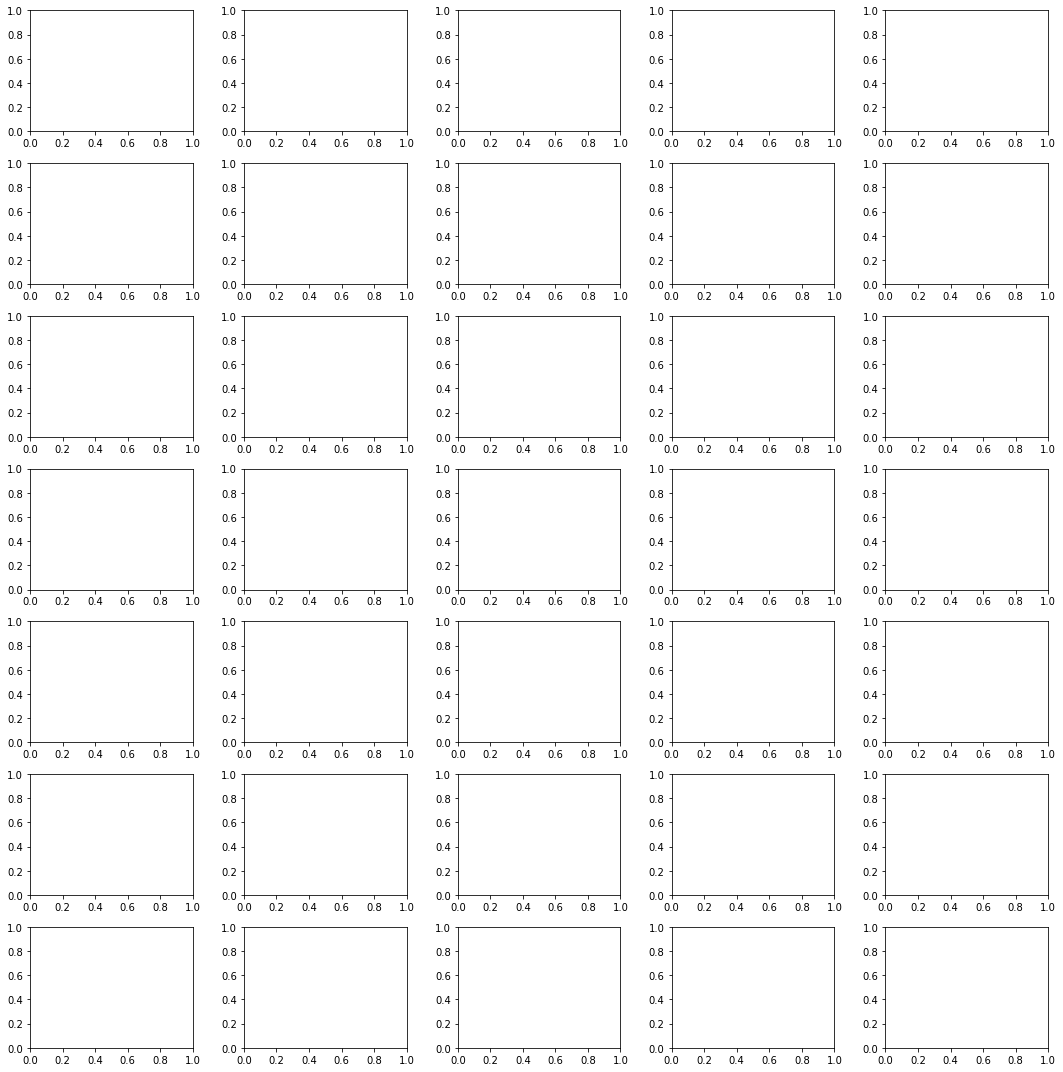

In [92]:
# cdf.dfs['replay_city1_(8)_2021-09-21_segment36']
plots = {}
city_median_partitions = {}
city_median_job_count = {}
for scans_key in cdf.dfs.keys():
    city_id = int(scans_key.split('_')[1][4:])
    datestr = scans_key.split('_')[3]
#     if city_id not in [1, 3, 12, 52, 458]:
#     if city_id not in [90, 146, 218, 799, 803]:
#         continue
    scans = cdf.dfs[scans_key]
    if len(scans) == 0:
        continue
    number_of_clusters, number_of_jobs = get_number_of_components_in_all_scans(scans)
    plots[(city_id, datestr)] = number_of_clusters
    city_median_partitions[city_id] = np.mean(np.array(number_of_clusters))
    city_median_job_count[city_id] = np.mean(np.array(number_of_jobs))
    print(city_id, np.mean(np.array(number_of_clusters)), np.mean(np.array(number_of_jobs)))
#     sns.histplot(number_of_clusters, bins=40)
#     break

print(plots)
NCOLS = 5
NROWS = 7#(len(plots) + NCOLS-1) // NCOLS
fig, axes = plt.subplots(NROWS, NCOLS, figsize=(15, 15))
for i, dict_item in enumerate(plots.items()):
    key, value = dict_item
    city_id, datestr = key
    continue
    ax = sns.histplot(
        value,
        bins=40,
        ax=axes[i%NROWS, i//NROWS],
    )
    ax.set_title('%s_%s' % (city_name[city_id], datestr))
    ax.set_ylabel('Count')
    ax.set_xlabel('Number of Clusters')
fig.tight_layout() 

In [101]:
single_radar_improvement = []
cluster_count_change = []
for city_id, radar_count in city_radar_count_map.items():
    if city_id not in city_median_partitions.keys():
        continue
    np_partitions = city_median_partitions[city_id]
    median_jobs = city_median_job_count[city_id]
    cluster_count_change.append(np_partitions / radar_count)
    if radar_count == 1:
        single_radar_improvement.append(np_partitions / radar_count)
    print(city_id, np_partitions / radar_count)
#     print(city_id, median_jobs / radar_count)

5 1.2792792792792793
7 0.9316239316239315
13 1.2094594594594594
12 0.7412280701754387
198 0.547008547008547
14 0.9696969696969697
8 0.4497354497354497
1 0.5331695331695332
6 0.3383838383838384
20 0.777027027027027
23 0.41724137931034483
15 0.6129032258064516
134 0.7192982456140351
25 0.5987654320987654
19 1.6923076923076923
208 0.41111111111111115
1542 0.2261904761904762
35 0.5875
27 0.8430769230769231
140 1.3396226415094339
21 0.49074074074074076
26 0.4470588235294118
227 0.33990147783251234
30 0.7037037037037037
24 0.896551724137931
10 0.7471264367816092
28 0.6224489795918368
4 0.7638888888888888
335 0.6052631578947368
50 0.7884615384615384
188 0.49382716049382713
22 1.7173913043478262
88 0.7169811320754716
41 0.18271604938271604
190 1.3387096774193548
192 0.6486486486486487
207 0.7888888888888889
187 0.9098360655737705
233 0.8958333333333334
189 0.31382978723404253
136 0.39181286549707606
93 0.3365853658536585
40 0.5571428571428572
45 0.2716049382716049
133 1.3243243243243243
142 0.

In [100]:
np.median(single_radar_improvement)

1.173913043478261

In [103]:
np.mean(cluster_count_change)

0.853500119941222